$$ \phi_i = C \sum_{S \subset D \backslash \{i\}} \frac{1}{{n-1} \choose {|S|}} [V(S \cup \{i\})-V(S)]$$

$$ \phi_i = \mathbb{E}_{\pi \sim \Pi} [V(S^i_{\pi} \cup {\{i\}})-V(S^i_{\pi})]$$

1. n = number of training samples
1. values = -np.inf * np.ones(n)
1. scores = [[] for _ in range(n)]
1. For i in (1,n):
    1. iteration = 0
    1. while iteration < max_iterations:
        1. Draw an n-permutation
        1. model.fit(samples(permutation(:index(i))))
        1. score_without = model.predict(test set)
        1. model.fit(samples(permutation(:index(i)+1)))
        1. score_with = model.predict(test set)
        1. old_moving_average = mean(scores(i))
        1. scores(i).push(score_with - score_without)
        1. new_moving_average = mean(scores(i))
        1. if abs(new_moving_average - old_moving_average) < eps then break
        1. old_moving_average = new_moving_average 
        1. iteration += 1
    1. values(i) = mean(scores(i))

In [13]:
%load_ext autoreload
import matplotlib.pyplot as plt

from functools import partial
from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from valuation.utils import Dataset
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
data = Dataset.from_sklearn(datasets.load_boston())
model = GradientBoostingRegressor()
model.fit(data.x_train, data.y_train)
predictions = model.predict(data.x_test)

/Users/fabio/miniconda3/envs/data_shapley/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 

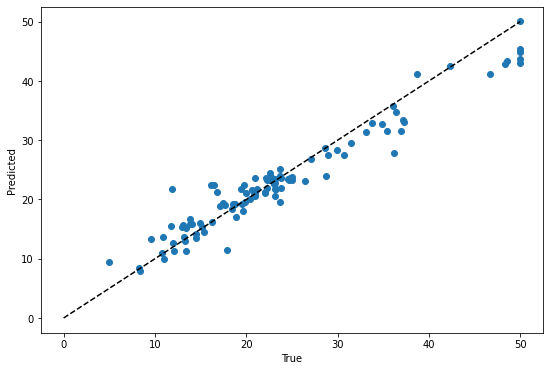

In [15]:
plt.figure(figsize=(9, 6))
plt.scatter(data.y_test, predictions)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('True')
plt.ylabel('Predicted');

In [16]:
%autoreload

In [17]:
from valuation.shapley import permutation_exact_shapley, truncated_montecarlo_shapley
from valuation.utils import map_reduce, Utility
from valuation.reporting.scores import compute_fb_scores
from valuation.reporting.plots import shapley_results

# Naive Shapley

We want to examine how the shapley values change with train and test data. In particular, we want to examine how robust data shapley values are to out of distribution input data. To do so, we will progressively add more and more outliers to our train dataset

In [21]:
def polynomial(coefficients, x):
    powers = np.arange(len(coefficients))
    return np.power(x, np.tile(powers, (len(x), 1)).T).T @ coefficients

def polynomial_dataset(coefficients: np.ndarray):
    """Coefficients must be for monomials of increasing degree"""
    from sklearn.utils import Bunch

    x = np.arange(-1, 1, 0.2)
    locs = polynomial(coefficients, x)
    y = np.random.normal(loc=locs, scale=0.3)
    db = Bunch()
    db.data, db.target = x.reshape(-1, 1), y
    poly = [f"{c} x^{i}" for i, c in enumerate(coefficients)]
    poly = " + ".join(poly)
    db.DESCR = f"$y \\sim N({poly}, 1)$"
    db.feature_names = ["x"]
    db.target_names = ["y"]
    return Dataset.from_sklearn(data=db, train_size=0.5), coefficients

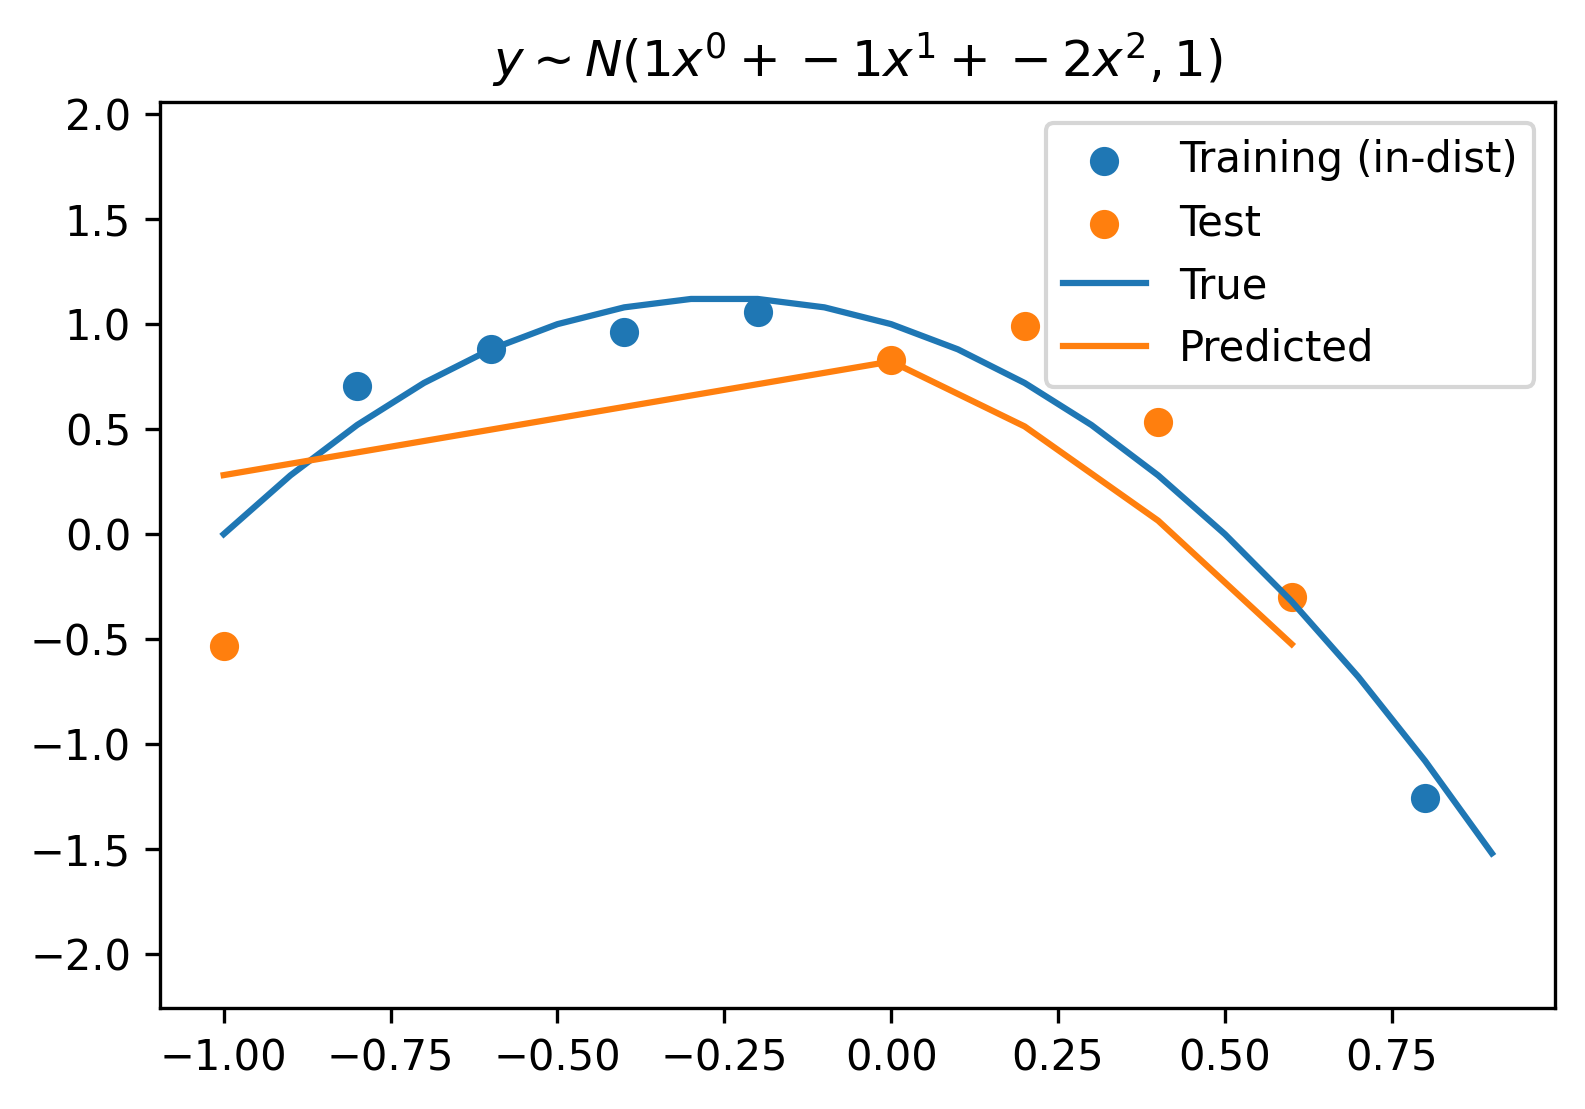

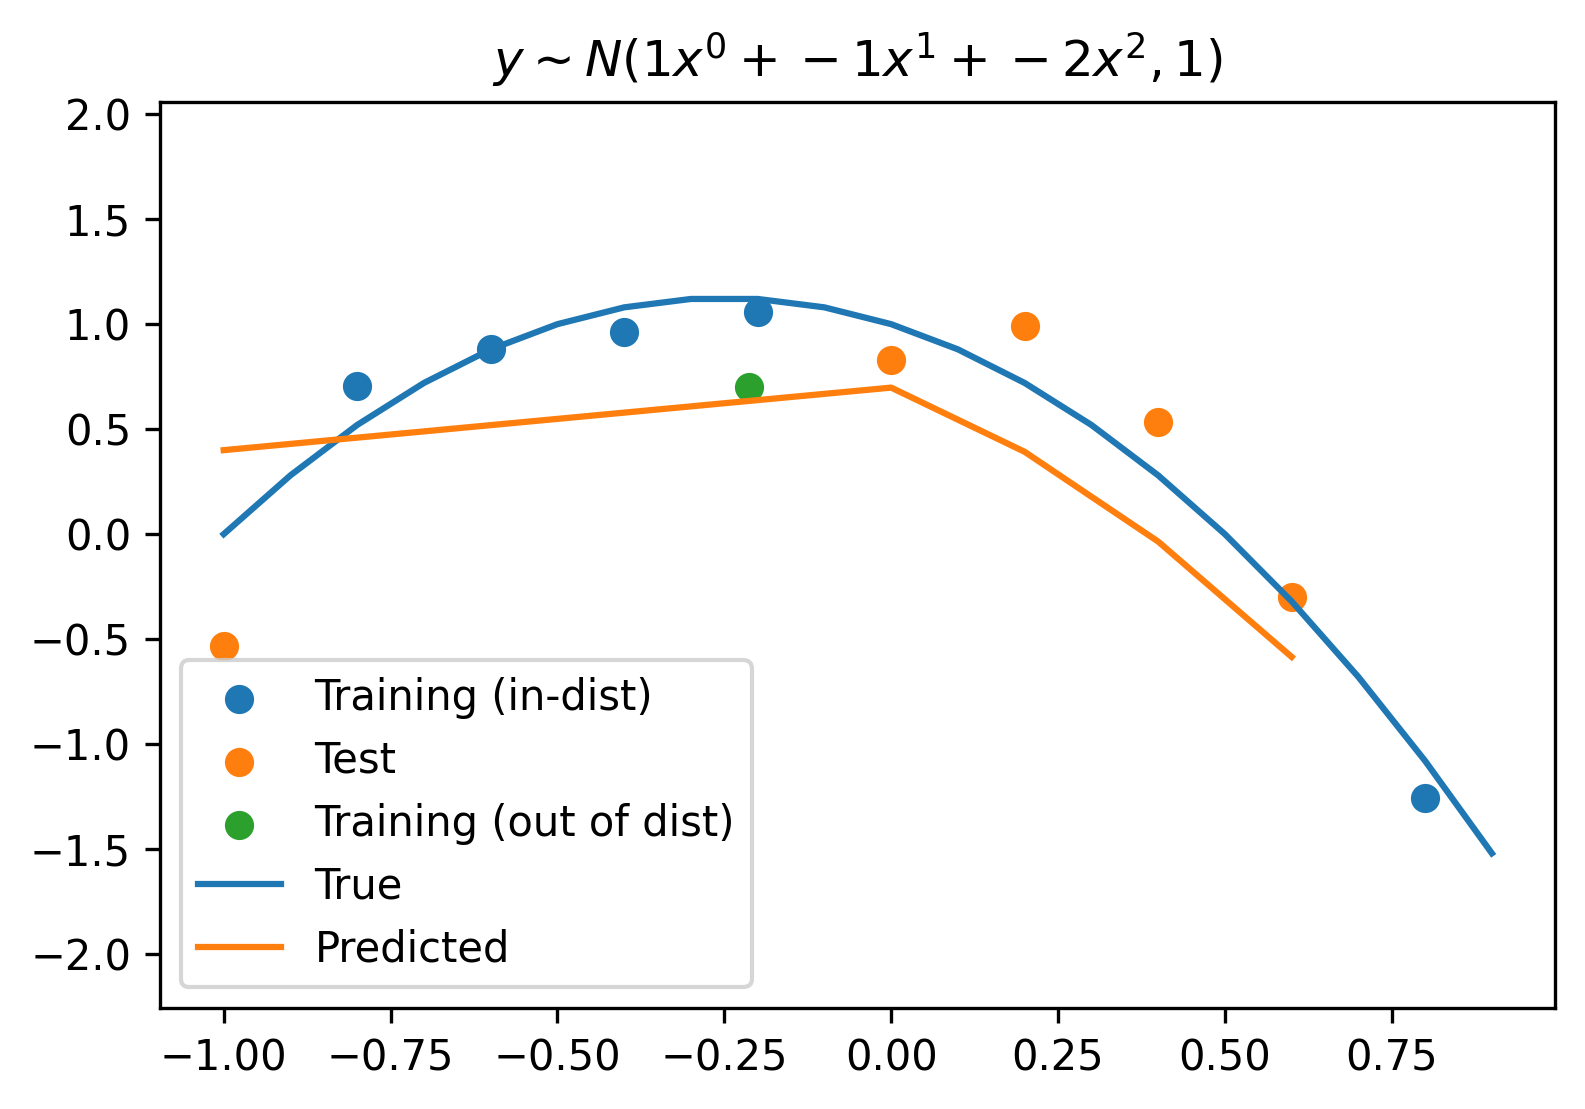

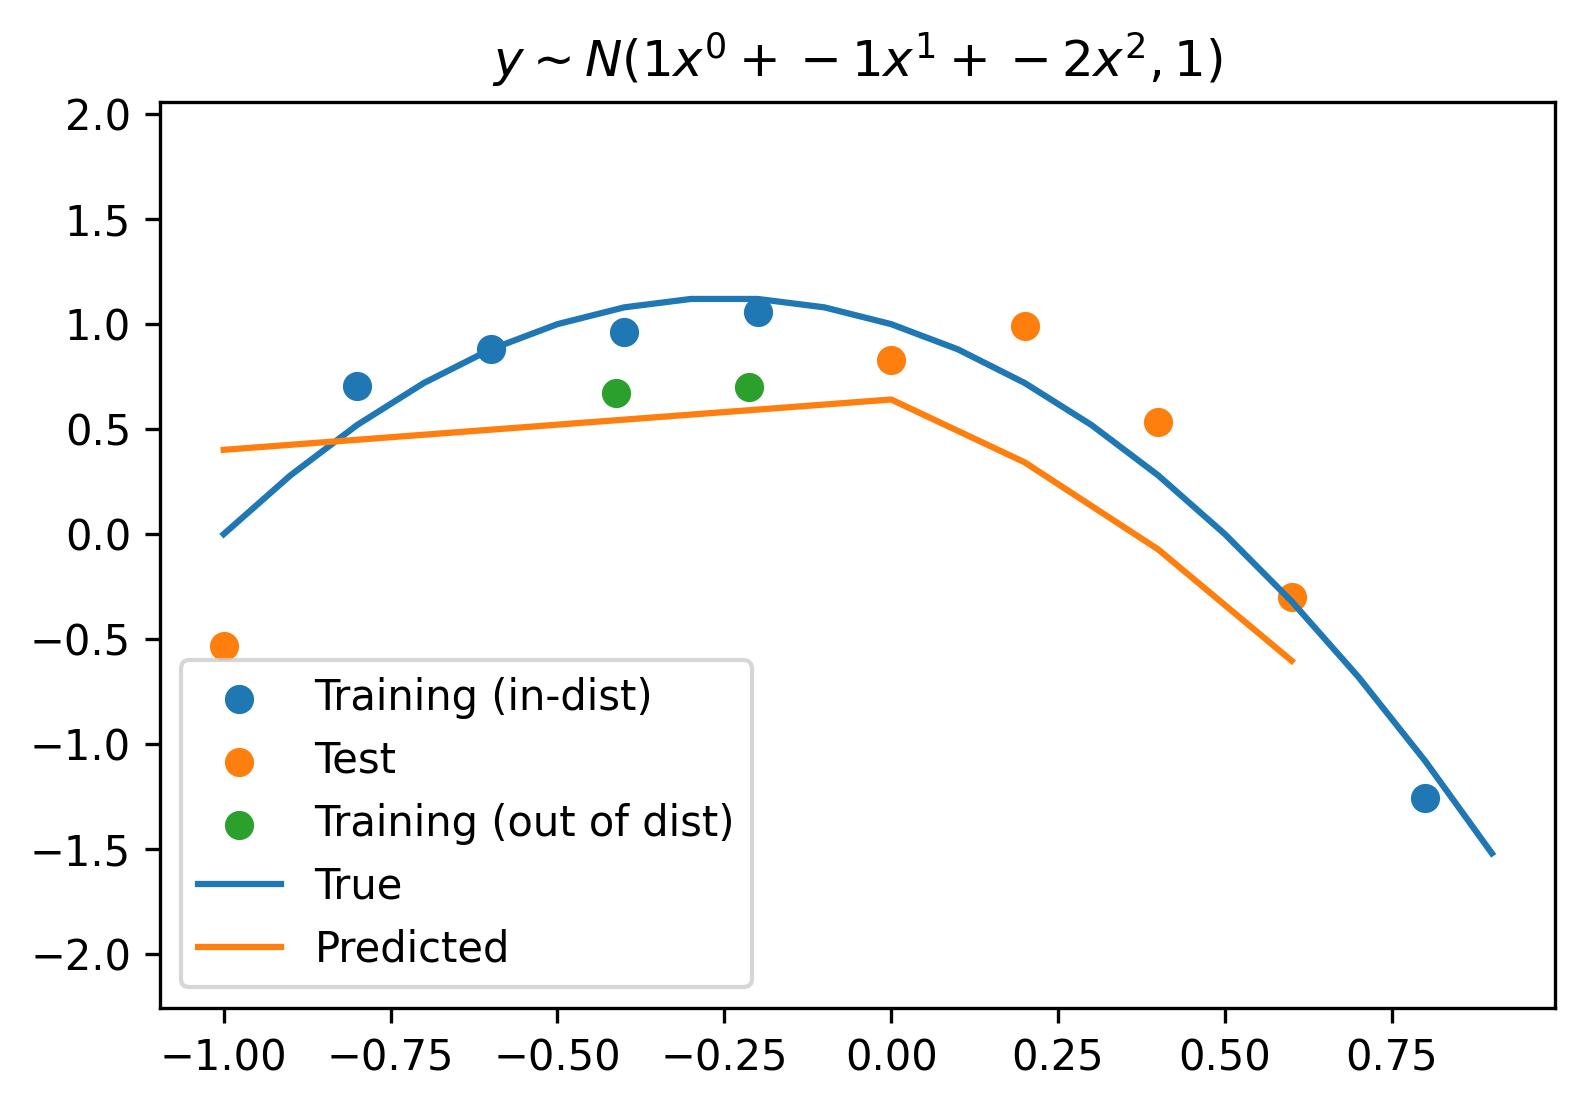

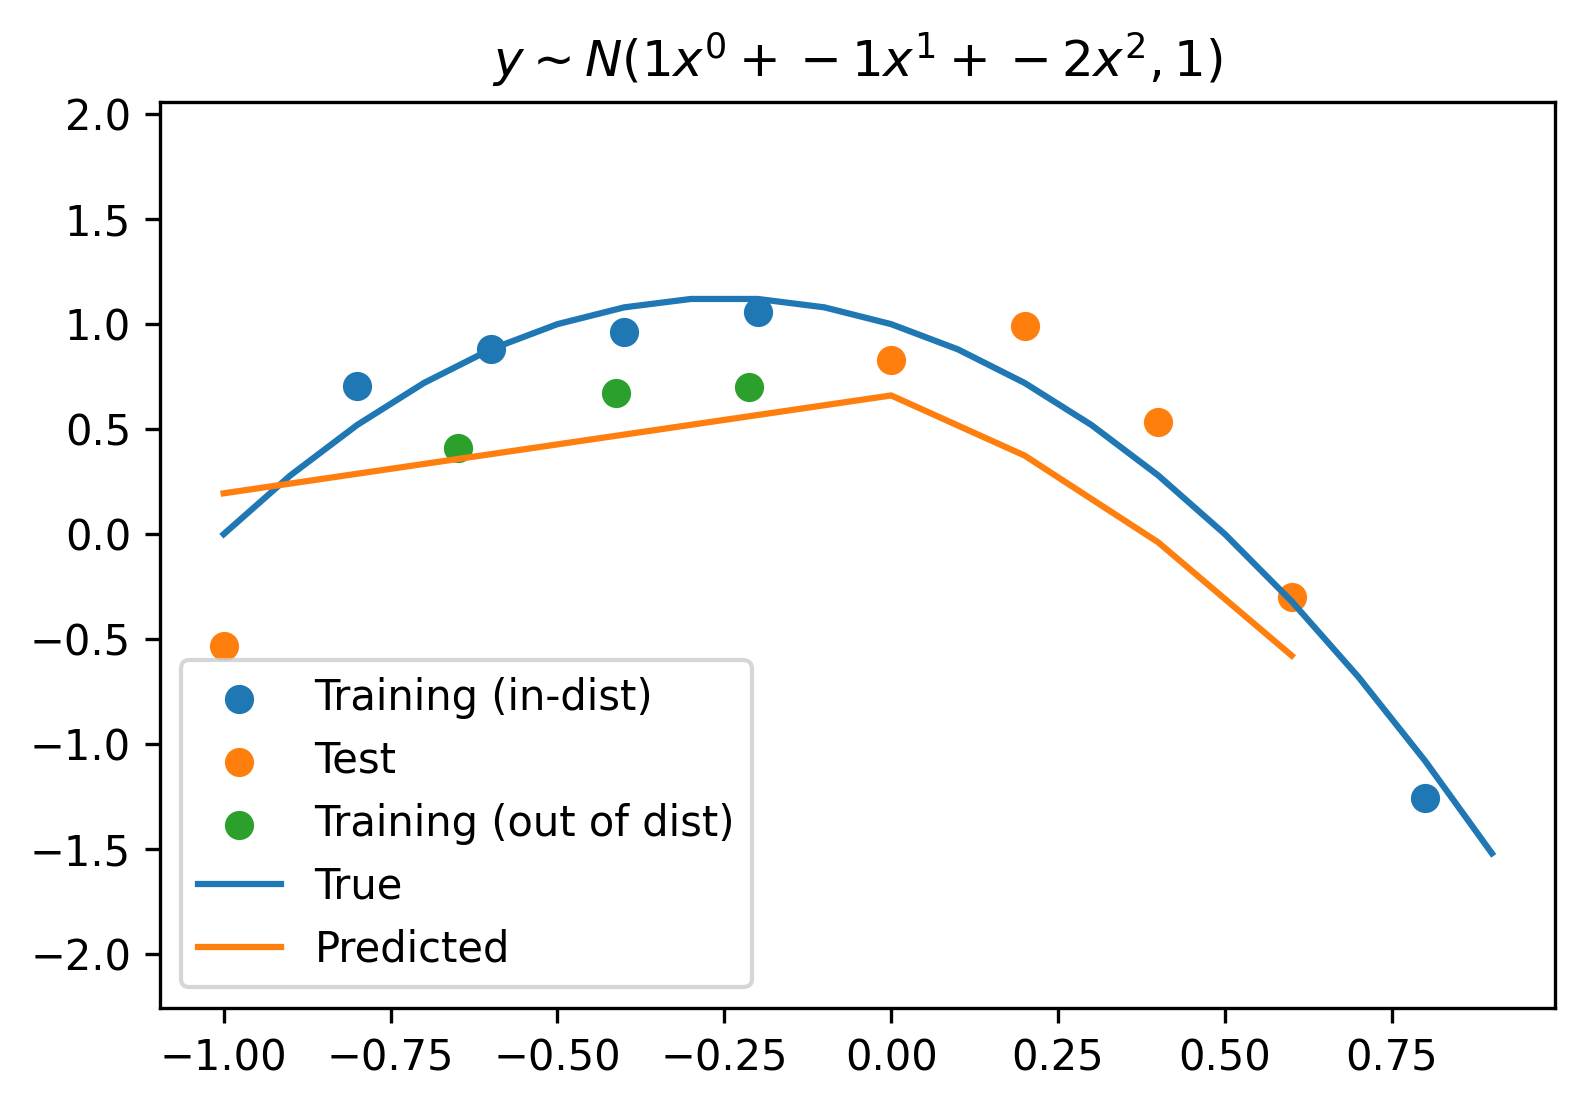

******
OrderedDict([(1, -0.254501892890004), (0, -0.04797289066860096), (2, -0.03947618158599998), (4, -0.033140663984958144), (3, -0.030564078325481737), (5, 0.0), (6, 0.0), (7, 0.0)])
******
[7, 6, 5, 3, 4, 2, 0, 1]
******
[-0.65, -0.41, -0.21, -0.8, -0.6, -0.4, -0.2, 0.8]
[0.41, 0.67, 0.7, 0.7, 0.88, 0.96, 1.06, -1.26]


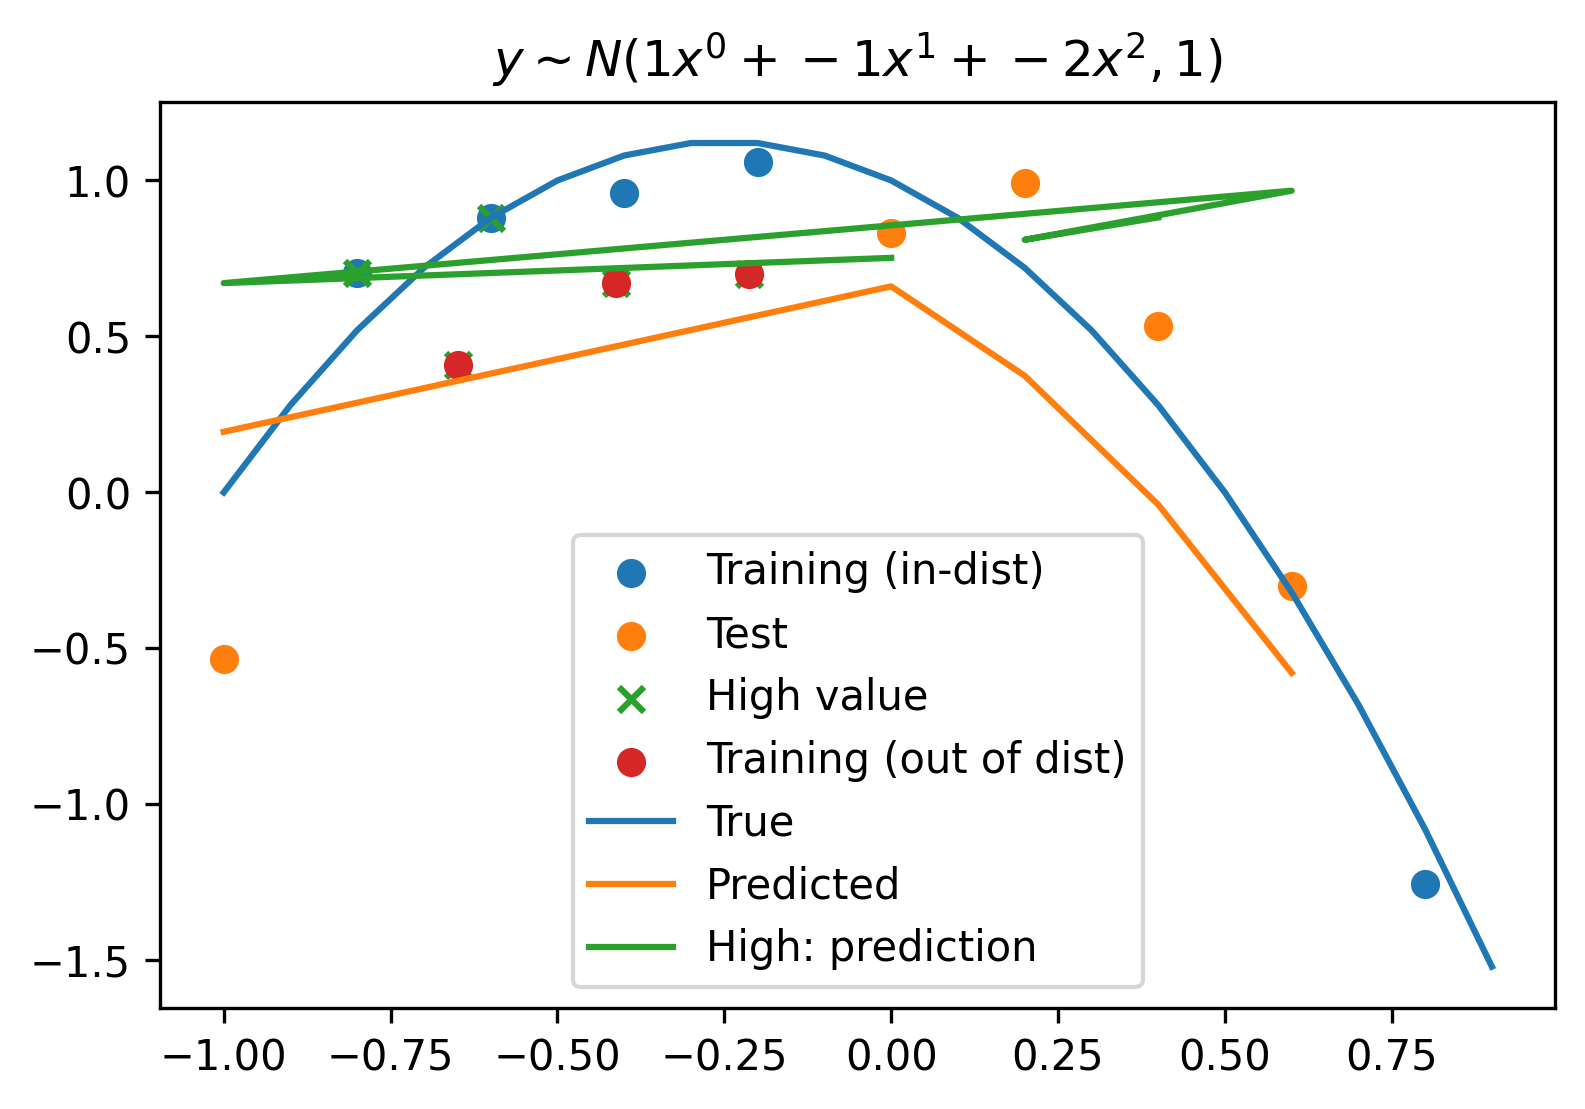

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
d, coeffs = polynomial_dataset(np.random.randint(-3, 3, size=3))  
model = make_pipeline(PolynomialFeatures(len(coeffs)-1), LinearRegression())

n = len(d)
model.fit(d.x_train, d.y_train)
predicted = [model.predict(d.x_test)]

x_cont = d.x_train.reshape(-1,) + np.random.uniform(-0.05, 0.05, size=len(d))
x_cont = x_cont[::2]
y_cont = polynomial(np.random.normal(loc=coeffs, scale=0.3), x_cont)
xtrain = np.concatenate([d.x_train, x_cont.reshape(-1, 1)], axis=0)
ytrain = np.concatenate([d.y_train, y_cont.reshape(-1,)], axis=0)
for i in range(len(d), len(xtrain)):
    model.fit(xtrain[:i+1], ytrain[:i+1])
    ypred = model.predict(d.x_test)
    predicted.append(ypred)

test_indices = np.argsort(d.x_test, axis=0).reshape(-1, )
xx = np.arange(-1, 1, 0.1)
yy = polynomial(coeffs, xx)

from matplotlib import pyplot as plt
for i, ypred in enumerate(predicted):
    plt.figure(dpi=300)
    plt.scatter(d.x_train[:n], d.y_train[:n], label="Training (in-dist)")
    plt.scatter(d.x_test, d.y_test, label="Test")

    if i > 0:
        plt.scatter(x_cont[:i], y_cont[:i], label="Training (out of dist)")
    plt.plot(xx, yy, label="True")
    plt.plot(d.x_test[test_indices], ypred[test_indices], label="Predicted")
    plt.ylim(min(d.y_train[:n].min(), y_cont.min()) - 1,
                max(d.y_train[:n].max(), y_cont.max()) + 1)
    plt.legend()
    plt.title(d.description)
    plt.show()

d.x_train = xtrain
d.y_train = ytrain

from valuation.shapley import combinatorial_exact_shapley
from valuation.utils import Utility
u = Utility(model, d, "neg_median_absolute_error")
values = combinatorial_exact_shapley(u, progress=False)

print("******")
print(values)
print("******")
high_to_low = list(reversed(values))
print(high_to_low)
print("******")
print(list(np.round(d.x_train[high_to_low].reshape(-1,), 2)))
print(list(np.round(d.y_train[high_to_low], 2)))

take = 5
plt.figure(dpi=300)
plt.scatter(d.x_train[:n], d.y_train[:n], label="Training (in-dist)")
plt.scatter(d.x_test, d.y_test, label="Test")
plt.scatter(d.x_train[high_to_low][:take], d.y_train[high_to_low][:take],
            marker='x', label='High value')
plt.scatter(x_cont, y_cont, label="Training (out of dist)")
plt.plot(xx, yy, label="True")
plt.plot(d.x_test[test_indices], predicted[-1][test_indices], label="Predicted")

model.fit(d.x_train[high_to_low][:take], d.y_train[high_to_low][:take])
ypred = model.predict(d.x_test)
plt.plot(d.x_test, ypred, label='High: prediction')
plt.title(d.description)

plt.legend()
plt.show()

# MCShapley

In [20]:
max_iterations = 200
utility = Utility(
    model,
    data,
    scoring=None,
    enable_cache=False,
)
fun = partial(permutation_exact_shapley, utility=utility, progress=True)
values_nmcs, hist_nmcs = map_reduce(fun, num_runs=10, num_jobs=160)

TypeError: map_reduce() missing 1 required positional argument: 'data'

In [ ]:
scores_nmcs = compute_fb_scores(model=model, data=data, values=values_nmcs)

In [ ]:
scores_nmcs.update({'max_iterations': max_iterations, 'score_name': "$R^2$"})
shapley_results(scores_nmcs)

# Truncated MC Shapley

In [ ]:
params = {'bootstrap_iterations': 200,
          'min_scores': 10,
          'score_tolerance': 0.1,
          'min_values': 10,
          'value_tolerance': 1e-2,
          'max_iterations': 0.5*len(data)}
fun = partial(truncated_montecarlo_shapley, 
              model, data, num_workers=160, worker_progress=False, **params)

In [ ]:
values_mcs, hist_mcs = map_reduce(fun, data=data, num_runs=10)

In [ ]:
scores_mcs = compute_fb_scores(model=model, data=data, values=values_mcs)

In [ ]:
scores_mcs.update({'max_iterations': params['max_iterations'], 'score_name': "$R^2$"})
shapley_results(scores_mcs)